<a href="https://colab.research.google.com/github/milomalas/ohayou-sekai/blob/main/statistika/PCA_HierarchyCluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align='center'>

ME3202 Analisis Data Cuaca dan Iklim II
# **Ujian Akhir Semester 2**
2020/2021

------
oleh : <br>
Hartono Wijaya - 12818004

</div>


# Soal
image.png

In [ ]:
!pip install netCDF4

import xarray as xr
import netCDF4 as nc

import numpy as np
import scipy.linalg as sclinalg
import sklearn.decomposition as skdc

!pip install --upgrade scikit-learn
!pip list | grep scikit-learn

import scipy.cluster.hierarchy as schy
import sklearn.cluster as skcst
import sklearn.metrics as skm

import matplotlib.pyplot as plt

Requirement already up-to-date: scikit-learn in /usr/local/lib/python3.7/dist-packages (0.24.2)
scikit-learn                  0.24.2        


In [ ]:
!pip install cartopy
!pip install --no-binary shapely shapely --force
import cartopy.crs as ccrs

  Using cached https://files.pythonhosted.org/packages/42/f3/0e1bc2c4f15e05e30c6b99322b9ddaa2babb3f43bc7df2698efdc1553439/Shapely-1.7.1.tar.gz
Skipping wheel build for shapely, due to binaries being disabled for it.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Shapely 1.7.1
    Uninstalling Shapely-1.7.1:
      Successfully uninstalled Shapely-1.7.1
    Running setup.py install for shapely ... done


# Data

image.png

- *TRMM Multi-satellite Precipitation Analysis* (TMPA)
- Southeast Asia : (15°LU 90°BT - 15°LS 150°BT)
- 1998 - 2015, daily
- NetCDF : `trmm3b42.daily.precip.indonesia.1998.2015.nc` (link: http://bit.ly/AndatData)
<div align='left'> ________________________________________________ </div>
- [X] Negative precipitation data conditioning
  > Drop negative values : `6574 -> 6562` <br>
  > Ignore NaN values during monthly sum (`xarray.DataArray.resample()`) <br> 

In [ ]:
# Otorisasi akses Drive
from google.colab import drive
drive.mount('/content/drive/')

!ls 'drive/MyDrive/Colab Notebooks/Data_Andat/'
#trmm3b42.daily.precip.indonesia.1998.2015.nc

# Membuka data
trmm_raw = xr.open_dataset('drive/MyDrive/Colab Notebooks/Data_Andat/trmm3b42.daily.precip.indonesia.1998.2015.nc')

# Terlalu berat/lama sehingga diperkecil
trmm = trmm_raw
#trmm = trmm_raw.coarsen(lat=2).mean().coarsen(lon=2).mean()
#trmm = trmm.sel(time=slice('2000', '2002'))
#trmm = trmm.sel(lat=slice(-12.5, 10), lon=slice(90, 145))

# Menghilangkan yang negatif
trmm = trmm.where(trmm.precip > -1, drop=True)
trmm

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
 CLIM_INDEX.csv			   stockholm_td_adj.dat
'data gabungan.xlsx'		   table13.1.txt
 data_prediksi.xlsx		   table4.7.txt
 GPCC_INA.ctl			   table8.5.txt
 GPCC_INA.dat			   tableA1.txt
 MEI_DMI_PR.txt			   tableA2.txt
 monthly.clim.idx.1948.2015.xlsx   tableA3.txt
 pasifik1.dat			   trmm3b42.daily.precip.indonesia.1998.2015.nc
 sst_nino3.dat


<xarray.Dataset>
Dimensions:  (lat: 122, lon: 242, time: 6562)
Coordinates:
  * lon      (lon) float64 89.88 90.12 90.38 90.62 ... 149.4 149.6 149.9 150.1
  * lat      (lat) float64 -15.12 -14.88 -14.62 -14.38 ... 14.62 14.88 15.12
  * time     (time) datetime64[ns] 1998-01-01 1998-01-02 ... 2015-12-31
Data variables:
    precip   (time, lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

### Visual check data

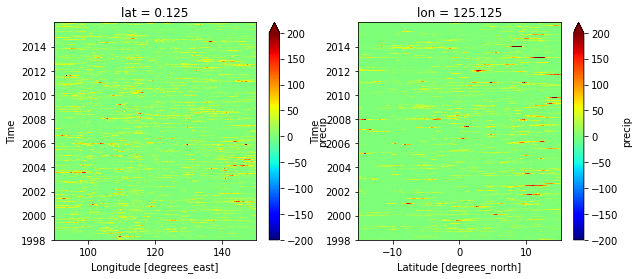

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
trmm.precip.sel(lat=0, method='nearest').plot(ax=ax[0], vmin=-200, vmax=200, cmap='jet')
trmm.precip.sel(lon=125, method='nearest').plot(ax=ax[1],  vmin=-200, vmax=200,cmap='jet')
plt.show()

------
# A. Nomor 1 : **Principal Component**
 1. [x] Hitung curah hujan <u> akumulasi bulanan</u>.
 2. [x] Normalisasi/standardisasi data curah hujan setiap titik <u> tanpa membuang rata-rata klimatologisnya</u>.
 3. [ ] Terapkan **_Principal Component Analysis_ Type-S** dari data A.1.)
 4. [x] Pilih beberapa mode komponen utama (PC) berdasarkan <u> uji signifikansi **Scree Test**</u>. Gambarkan pola spasial dan temporal masing-masing.
 5. [x] Terapkan **_Fast Fourier Transform_** dari masing-masing mode terpilih.
 6. Identifikasi fenomena-fenomena yang direpresentasikan mode-mode tersebut.

## A.1. Akumulasi bulanan
`xarray.DataArray.resample(time='1M').sum()`

## A.2. Standardisasi/normalisasi
$\text{normal} = \frac{\text{data} - \text{mean}(\text{data})}{\text{stdv}(\text{data})}$
<br> `mean = xarray.DataArray.mean(dim='time')`
<br> `stdv = xarray.DataArray.std(dim='time')`

/usr/local/lib/python3.7/dist-packages/xarray/core/common.py:1106: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset


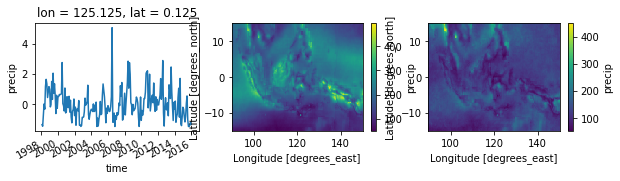

<xarray.DataArray 'precip' (time: 216, lat: 122, lon: 242)>
array([[[-0.48351956, -0.5002571 , -0.58960747, ...,  3.20615783,
          3.03149038,  4.28972573],
        [-0.0093083 , -0.12732212, -0.40963199, ...,  2.27069119,
          3.32124944,  3.12018514],
        [-0.53948018, -0.63252137, -0.61925881, ...,  2.38175028,
          3.19081961,  2.79040392],
        ...,
        [-1.01509736, -1.0100699 , -0.98511932, ..., -0.82788143,
         -0.80734733, -0.80389541],
        [-1.00449611, -0.96112025, -0.98041918, ..., -0.83578449,
         -0.84603909, -0.81502417],
        [-0.9505511 , -0.93538488, -0.97187679, ..., -0.8894441 ,
         -0.90339025, -0.86708096]],

       [[-0.41143851, -0.41072123, -0.7058483 , ...,  1.72086901,
          1.57967676,  1.49026888],
        [-0.57089146, -0.57009158, -0.75039113, ...,  1.71480213,
          1.39961828,  1.42978262],
        [-0.53639374, -0.77211867, -0.80543184, ...,  1.5637503 ,
          1.25571735,  1.30791507],
        ...,
        [-1.01525481, -1.0099188 , -0.98511932, ..., -0.85194523,
         -0.79720159, -0.79018705],
        [-1.00449611, -0.96097629, -0.98041918, ..., -0.83114875,
         -0.8035886 , -0.77349044],
        [-1.00119834, -0.99787107, -1.00017052, ..., -0.83425605,
         -0.80779245, -0.891669  ]],

       [[-0.6305005 , -0.5256124 , -0.62287376, ...,  0.23275424,
          0.1599077 ,  0.14360329],
        [-0.64412355, -0.54170892, -0.60322725, ...,  0.59190133,
          0.37174561,  0.75911593],
        [-0.66514245, -0.65483944, -0.58962139, ...,  0.98667498,
          0.86226914,  1.02381169],
        ...,
        [-1.01525481, -1.0100699 , -0.98511932, ..., -0.89298034,
         -0.86999728, -0.82409721],
        [-1.00449611, -0.96112025, -0.98041918, ..., -0.87750617,
         -0.83832082, -0.82843879],
        [-1.00119834, -0.99787107, -1.00017052, ..., -0.82084586,
         -0.82650194, -0.8469875 ]],

       ...,

       [[-0.29788064, -0.24036539, -0.17282292, ..., -0.73467342,
         -0.75384295, -0.75064425],
        [-0.32075039, -0.15002824, -0.09484296, ..., -0.73904718,
         -0.79353106, -0.86323699],
        [-0.42131356, -0.29468717, -0.27571529, ..., -0.82162696,
         -0.88301379, -0.9026843 ],
        ...,
        [ 0.1451755 , -0.08004942, -0.0815663 , ...,  2.23227374,
          1.91399406,  1.87404499],
        [ 0.21880505, -0.0221252 , -0.13636986, ...,  2.95754026,
          2.63670148,  2.74242995],
        [ 0.35334235,  0.10401945,  0.13509616, ...,  3.23444442,
          3.168615  ,  3.15954111]],

       [[-0.33976012, -0.30811155, -0.07111218, ..., -0.61857268,
         -0.64742604, -0.60986523],
        [-0.40015371, -0.45575001, -0.3635941 , ..., -0.69228071,
         -0.76417773, -0.70294237],
        [-0.51919785, -0.51086605, -0.45729661, ..., -0.63341239,
         -0.69043257, -0.66601653],
        ...,
        [-0.3352143 , -0.45795051, -0.51818252, ..., -0.35521778,
         -0.19987109, -0.18725965],
        [-0.29331082, -0.41280933, -0.424762  , ..., -0.52235681,
         -0.42024787, -0.3509299 ],
        [-0.04716037, -0.08145781, -0.16757023, ..., -0.56502088,
         -0.53663298, -0.51068656]],

       [[-0.32727681, -0.1674689 , -0.08373043, ...,  0.38841873,
          0.38111137,  0.30844707],
        [-0.24875255, -0.01054775,  0.23450506, ...,  0.65383531,
          0.59898088,  0.55723548],
        [-0.2458273 ,  0.07115401,  0.4234772 , ...,  0.99836066,
          0.75354987,  0.70578938],
        ...,
        [-0.86441462, -0.81061791, -0.87404249, ..., -0.66855378,
         -0.65059564, -0.58384014],
        [-0.92283861, -0.86640022, -0.79588958, ..., -0.76238524,
         -0.79767126, -0.72963495],
        [-0.91237089, -0.973029  , -0.98946478, ..., -0.82265108,
         -0.81368722, -0.80574305]]])
Coordinates:
  * time     (time) datetime64[ns] 1998-01-31 1998-02-28 ... 2015-12-31
  * lon      (lon) float64 89.88 90.12 90.38 90.62 ... 149.4 149.6 149.9 150.1
 

In [ ]:
# Dataset input, monthly sum
data = trmm.precip.resample(time="1M").sum()

# Normal
allmean = data.mean(dim='time')
allstdv = data.std(dim='time')
data = (data - allmean)/allstdv

# Cek
fig, ax = plt.subplots(1,3, figsize=(10,2))
data.sel(lat=0, lon=125, method='nearest').plot(ax=ax[0])
allmean.plot(ax=ax[1]);  allstdv.plot(ax=ax[2])
plt.show()

data

### Visual check data

<function matplotlib.pyplot.show>

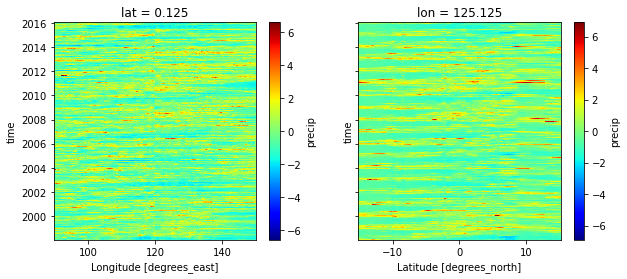

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4), sharey=True)
data.sel(lat=0, method='nearest').plot(cmap='jet', ax=ax[0])
data.sel(lon=125, method='nearest').plot(cmap='jet', ax=ax[1])
plt.show

In [ ]:
#for h in np.arange(0, len(data.time), 45):
#  fig, ax = plt.subplots(5,9, figsize=(20,10), sharey=True, sharex=True)
#  for i in range(5):
#    for j in range(9):
#      k = i*8 + j
#      data.isel(time=k+h).plot(ax=ax[i,j], cmap='Blues')
#      ax[i,j].set_xlabel(""); ax[i,j].set_ylabel("")
#  plt.show()

## A.3. Spatial PCA


In [ ]:
##### Preparation #####
pca_data = data.copy(deep=True)

# Data dimensions/shapes
print("Dimensions: ", pca_data.dims, pca_data.shape, '\n')
n_time = len(pca_data.time)
n_lat  = len(pca_data.lat)
n_lon  = len(pca_data.lon)

# Reshape data (time, lat*lon).Transpose = (lat*lon, time)
pca_data = np.reshape(pca_data.values, (n_time, n_lat*n_lon)).T
m_n = pca_data.shape
print("Reshape to [m x n] :", m_n, '\n')

# Subtract means of/from every row
row_means = np.mean(pca_data, axis=1, keepdims=True)
pca_data = pca_data - row_means

# Drop NaNs
pca_data = pca_data[~np.isnan(pca_data).any(axis=1), :]
print("Removed NaN :", pca_data.shape, '\n')
pca_data

Dimensions:  ('time', 'lat', 'lon') (216, 122, 242) 

Reshape to [m x n] : (29524, 216) 

Removed NaN : (29524, 216) 



array([[-0.48351956, -0.41143851, -0.6305005 , ..., -0.29788064,
        -0.33976012, -0.32727681],
       [-0.5002571 , -0.41072123, -0.5256124 , ..., -0.24036539,
        -0.30811155, -0.1674689 ],
       [-0.58960747, -0.7058483 , -0.62287376, ..., -0.17282292,
        -0.07111218, -0.08373043],
       ...,
       [-0.8894441 , -0.83425605, -0.82084586, ...,  3.23444442,
        -0.56502088, -0.82265108],
       [-0.90339025, -0.80779245, -0.82650194, ...,  3.168615  ,
        -0.53663298, -0.81368722],
       [-0.86708096, -0.891669  , -0.8469875 , ...,  3.15954111,
        -0.51068656, -0.80574305]])

### Sklearn PCA
[`sklearn.decomposition.PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

`sklearn.decomposition.PCA().explained_variance_` = Eigenvalue = `evals[:n_time]`

`sklearn.decomposition.PCA().components_` = Eigenvector rows = `evect[:,:n_time].T` ????



> Linear dimensionality reduction using Singular Value Decomposition of the data to project it to a lower dimensional space. The input data is centered but not scaled for each feature before applying the SVD.
>
> It uses the LAPACK implementation of the full SVD or a randomized truncated SVD by the method of Halko et al. 2009, depending on the shape of the input data and the number of components to extract.


In [ ]:
import sklearn.decomposition as skdc

# Fitting
sk_pca = skdc.PCA().fit((pca_data).T)

print("evals (var), evect col (transf) : ", [sk_pca.explained_variance_.shape, sk_pca.components_.T.shape], '\n')

evals (var), evect col (transf) :  [(216,), (29524, 216)] 



### Covariance eigen PCA
lama dan bila data fullsize crash (full RAM)

- Reshape data into 2D
  > $X$ `m x n` : `m` grid stations (`nlat * nlon`) **x** `n` time observations (`ntime`)
- Subtract means of each row (per `m`)
- Calculate covariance matrix
  > Transformation: $Y \equiv P X$, with:
  > - $Y$ : score (projected) matrix <br>
  > - $P$ : loading (transforming) matrix <br>
  >   - $P$ such that $cov(Y) = C_Y \equiv \frac{1}{n-1} Y Y^T$ is diagonalised, --> $P=E^T$ <br>
  >   - Rows of $P$ is the principal component of $X$ & is orthonormal

  > Covariance matrix: $C_Y \equiv \frac{1}{n-1} Y Y^T$
- Calculate eigens of covariance matrix $C_Y$
  > Eigenvalues  : variances, stretch, temporal pattern. <br>
  > Eigenvectors : principal component, rotation, spatial pattern.

Eigendecomposition: $A$ : n **x** n \
$A = Q \Lambda Q^{-1}$
derived from:
$
\begin{aligned}
A v &= \lambda v \ \text{ (right eigenvector)}\\
A Q &= Q \Lambda\\
A &=  Q \Lambda Q^{-1}
\end{aligned}
$
<br>
where $Q$ : matrix with eigenvector columns, <br>
and $\Lambda$ : diagonal matrix of eigenvalues

-----

`scipy.linalg.eig()` returns <br>
`w` : (M,) complex ndarray
> The eigenvalues, each repeated according to its multiplicity

`vl`: (M,M) double or complex ndarray
> The normalized left eigenvector corresponding to the eigenvalue `w[i]` is the column `vl[:,i]`.

`vr`: (M,M) double or complex ndarray
> The normalized right eigenvector corresponding to the eigenvalue `w[i]` is the column `vr[:,i]`.
-----

Covariance: $C_Y$ : m **x** m eigendecomposition of matrix $Y$ : m **x** n \
$$
\begin{aligned}
C_Y &= \frac{1}{n-1}YY^T \\
    &= \frac{1}{n-1}(PX)(PX)^T \\
    &= \frac{1}{n-1}P (X X^T) P^T
\end{aligned}
\implies A =  Q \Lambda Q^{-1}
$$
thus $Q=P$ : matrix with eigenvector columns, --> `vr` (default: `right=True`) --> `evect`<br>
and $(XX^T) = \Lambda$ : diagonal matrix of eigenvalues --> `w` --> `evals`

-----
`score = np.dot(evect, pca_data) = evect @ pca_data` : $Y = PX$ <br>
$$Y \equiv PX$$
$X$ : (m **x** n) --> `pca_data`\
$P$ : matrix that transform $X$ into $Y$ (m **x** m) --> eigenvector ($P = E^T$) --> `evect`\
$Y$ : projected $X$ (m **x** n) --> `score`


In [ ]:
# Calculate covariance matrix
#covariance = pca_data @ pca_data.T /(m_n[1] - 1)
#covariance = np.cov(pca_data)
#print("Covariance: ", covariance.shape,"\n")

# Calculate covariance's eigens
# evect = PC, evals = variances
#evals, evect = sclinalg.eig(covariance) #default: right=True (right eigenvector)
#print("evals, evect : ", [evals.shape, evect.shape], '\n')

# Sort evector (PC), evals (variance), according to variance (descending)
# Sort eigens -> get eigenvalue ranks -> rearrange evector, evals
#ranks = np.argsort(evals)[::-1] # Descending order
#evals_unsort = np.copy(evals) ; evals = evals[ranks]
#evect_unsort = np.copy(evect) ; evect = evect[ranks]

Sklearn PCA vs Covariance Eigen PCA

In [ ]:
#plt.plot(sk_pca.explained_variance_)
#plt.plot(evals[:n_time])
#plt.show()

#plt.plot(sk_pca.components_[:,1], '-o')
#plt.plot(evect[1,:n_time].T.real, '-o')
#plt.plot(sk_pca.components_[:,1] - evect[1,:n_time].T.real)
#plt.show

#print(sk_pca.components_[:,1], evect[1,:n_time].T.real, sk_pca.components_[:,1] - evect[1,:n_time].T.real)

## A.4. Tinjau principal component

Sklearn PCA or Covariance Eigen PCA???

|                | Sklearn PCA                | Covar Eigen |
|----------------|----------------------------|-------------|
| Variance       | `sk_pca.explained_variance_` | `evals`       |
| PC <br> (transform, <br>loading) | `sk_pca.components_.T`         | `evect`       |

In [ ]:
# Choose which method
#variance  = evals
#component = evect
variance  = sk_pca.explained_variance_
component = sk_pca.components_.T

#----------------------------------------------------------------
# Calculate score matrix (Y in Y=PX) (projected data) [pc, obs]
#score = np.dot(evect, pca_data)
score = component.T @ pca_data
print("score matrix : ", score.shape, '\n')

# Variance (evals) -> Percent variance 
percent_var = variance.real *100 / sum(variance.real)

score matrix :  (216, 216) 



### Scree Plot
PC vs Variance

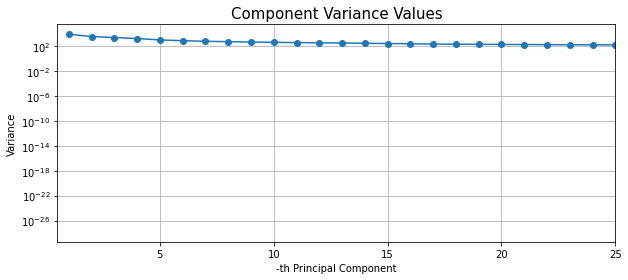

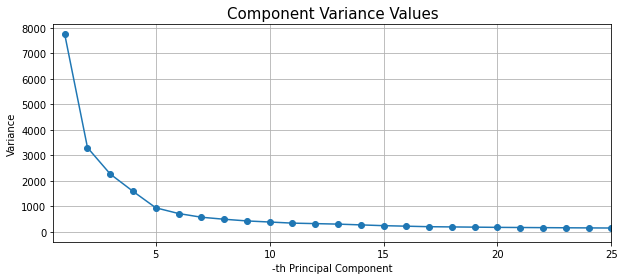

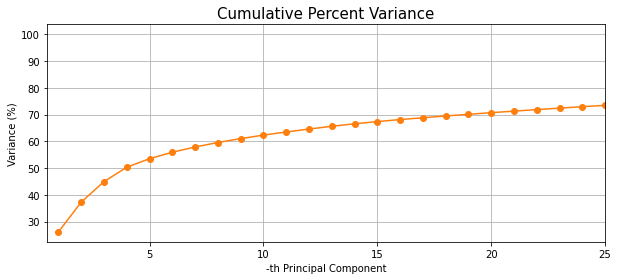

In [ ]:
# Cek (Scree Plot)
PC_index = np.arange(1, len(variance)+1)
xlab = '-th Principal Component'
ylab = 'Variance'
#xlimit = None
xlimit = [0.5, 25]
p, l = 10,4   # Figure size

# Variance value semilogy scale
plt.figure(figsize=(p, l))
plt.title('Component Variance Values', size=15)
plt.semilogy(PC_index, variance, '-o')
plt.xlabel(xlab); plt.ylabel(ylab)
plt.xlim(xlimit)
plt.grid(); plt.show()

# Variance value linear scale
plt.figure(figsize=(p, l))
plt.title('Component Variance Values', size=15)
plt.plot(PC_index, variance, '-o')
plt.xlabel(xlab); plt.ylabel(ylab)
plt.xlim(xlimit)
plt.grid(); plt.show()

# Percent variance linear scale
plt.figure(figsize=(p, l))
plt.title('Percent Variance', size=15)
plt.plot(PC_index, percent_var, '-o')
plt.xlabel(xlab); plt.ylabel(ylab+" (%)")
plt.xlim(xlimit)
plt.grid(); plt.show()

# Cumulative percent variance linear scale
plt.figure(figsize=(p, l))
plt.title('Cumulative Percent Variance', size=15)
plt.plot(PC_index, np.cumsum(percent_var), '-o', color='tab:orange')
plt.xlabel(xlab); plt.ylabel(ylab+" (%)")
plt.xlim(xlimit)
plt.grid(); plt.show()

In [ ]:
np.cumsum(percent_var[:4])

array([26.14654819, 37.29237223, 44.94684248, 50.3124408 ])

## **Pilih Principal Component**

Sehingga ke bawah sama semua

In [ ]:
chosen_PC = np.arange(1,6, dtype=int) #Nanti akan dikurangi 1 jadi mulai dari 1. Endpoint tidak termasuk
print("Chosen Principal Components: ", chosen_PC, "\n")

Chosen Principal Components:  [1 2 3 4 5] 



### Pattern plot 
Spatial pattern (component, EOF) --> `spatial_patt[~np.isnan(spatial_patt)] = component[:, i_PC-1]` \
Temporal pattern (variance) --> `tempo_patt = score[i_PC-1, :]`


In [ ]:
print("Principal Components: ", chosen_PC, "\n")

##### Spatial pattern (component, EOF) (semuanya)
# Ambil bentuknya
PC_evects = np.copy(data.values[0])
lat = np.copy(data.lat.values)
lon = np.copy(data.lon.values)
print("[PC_evects, lat, lon].shapes: ", [PC_evects.shape, lat.shape, lon.shape], "\n")

# Buat array besar
spatial_EOF = np.empty((component.shape[1], n_lat, n_lon))

# Reshape
for i in range(component.shape[1]):
  PC_evects[~np.isnan(PC_evects)] = component[:, i]
  spatial_EOF[i,:,:] = PC_evects

# Ubah ke xarray DataArray
spatial_EOF = xr.DataArray(spatial_EOF, name='spatial_EOF', dims=['princomp', 'lat', 'lon'], 
                            coords={'princomp': (range(1,component.shape[1]+1)), 'lat':lat, 'lon':lon},
                            attrs={'description':'Reshaped eigenvectors of PCA data'})

spatial_EOF

Principal Components:  [1 2 3 4 5] 

[PC_evects, lat, lon].shapes:  [(122, 242), (122,), (242,)] 



<xarray.DataArray 'spatial_EOF' (princomp: 216, lat: 122, lon: 242)>
array([[[-2.44426307e-03, -2.47057182e-03, -2.96169200e-03, ...,
         -6.66124542e-03, -6.67088793e-03, -6.66153303e-03],
        [-2.77147245e-03, -2.64464224e-03, -2.62042776e-03, ...,
         -7.15674806e-03, -7.21015111e-03, -7.25901207e-03],
        [-3.31387569e-03, -2.85140557e-03, -2.66866367e-03, ...,
         -7.27936676e-03, -7.23781010e-03, -7.35085471e-03],
        ...,
        [ 8.26627343e-03,  7.99001864e-03,  8.00253583e-03, ...,
          7.96029250e-03,  7.92065112e-03,  7.61963407e-03],
        [ 8.53112683e-03,  8.04535548e-03,  8.11826474e-03, ...,
          7.86172964e-03,  7.76256555e-03,  7.69873676e-03],
        [ 8.46040716e-03,  8.43284805e-03,  8.48573451e-03, ...,
          7.58467899e-03,  7.53299113e-03,  7.67220303e-03]],

       [[-1.66813584e-03, -2.26280163e-03, -2.90916678e-03, ...,
         -3.09137532e-05,  2.66934682e-04, -1.33996532e-04],
        [-1.66655071e-03, -2.25753404e-03, -2.55652815e-03, ...,
         -5.92717285e-05, -2.28002323e-06,  4.76017754e-06],
        [-1.63914086e-03, -2.35099700e-03, -2.58285537e-03, ...,
         -1.72527904e-05,  5.00805010e-05,  2.57109890e-05],
        ...,
        [ 4.90766234e-03,  4.95063733e-03,  4.43955056e-03, ...,
         -2.27703486e-03, -2.42554300e-03, -2.65603646e-03],
        [ 4.66425338e-03,  4.56028205e-03,  4.44903467e-03, ...,
         -2.94317004e-03, -2.94735745e-03, -2.78287381e-03],
        [ 4.44194887e-03,  4.29273011e-03,  4.09398983e-03, ...,
         -2.47764442e-03, -2.39932459e-03, -2.59620502e-03]],

       [[-1.31950957e-04, -5.23163653e-04, -1.30404858e-03, ...,
         -2.70490425e-03, -2.79087232e-03, -2.55358031e-03],
        [-6.03330852e-04, -8.52349952e-04, -1.04068394e-03, ...,
         -3.09698935e-03, -3.26226461e-03, -2.87866813e-03],
        [-1.34540553e-03, -1.32910527e-03, -1.69167655e-03, ...,
         -3.00740339e-03, -2.84916906e-03, -2.50377295e-03],
        ...,
        [-4.37125361e-03, -5.17037091e-03, -5.11674756e-03, ...,
          1.49364502e-03,  1.41776077e-03,  1.07178199e-03],
        [-4.25681040e-03, -5.13816811e-03, -4.89251405e-03, ...,
          1.98883406e-03,  1.66463291e-03,  1.16264532e-03],
        [-3.91271892e-03, -4.52113711e-03, -4.54915966e-03, ...,
          1.81955721e-03,  1.42258154e-03,  1.73904132e-03]],

       ...,

       [[-3.97700454e-03, -6.48837231e-03, -9.45181331e-03, ...,
          7.08269815e-03,  5.22230548e-03, -3.16726749e-03],
        [-6.42919769e-03, -4.84510056e-03, -4.24686592e-03, ...,
          7.76920276e-03, -1.33942440e-03, -2.50220566e-05],
        [-6.20846462e-03, -5.74539064e-03, -1.32277948e-03, ...,
          2.41713460e-03, -4.65150322e-03,  4.25791017e-03],
        ...,
        [-2.18280072e-03, -7.22487198e-03, -1.11277931e-02, ...,
         -3.39252297e-03, -2.66189896e-03,  4.80734565e-03],
        [-1.38661405e-03, -3.86172759e-04, -6.36137808e-03, ...,
         -2.99197275e-03, -4.05870528e-03,  3.23674439e-03],
        [-4.17740675e-03, -7.12732900e-03, -8.83380010e-03, ...,
          1.30810472e-04, -3.33101697e-03,  1.73753669e-03]],

       [[-4.83580713e-03, -3.76795011e-03, -1.95329974e-03, ...,
         -6.57879799e-03, -5.39502005e-03, -4.78686197e-03],
        [-8.83367228e-03, -4.01938647e-03,  1.11809991e-03, ...,
         -2.88541857e-03, -2.67721020e-03, -1.64991132e-03],
        [-1.30820960e-02, -8.33775501e-03, -2.67536087e-03, ...,
         -2.45017834e-03, -3.21102605e-03, -9.28666302e-04],
        ...,
        [-5.94101477e-03, -7.31085419e-03, -4.10937592e-03, ...,
          7.87399782e-03,  1.30038347e-03,  8.44380887e-03],
        [-8.28891414e-03, -7.47059792e-03, -6.41465359e-03, ...,
          1.66532932e-02,  8.82938504e-03,  1.79992902e-02],
        [-8.25841322e-04, -4.38520491e-03,  2.94908792e-03, ...,
          1.83284021e-02,  2.00529223e-02,  2.54689237e-02]],

       [[-2.60015380e-02, -1.36859146e-01,  1.27716255e-01, ...

Chosen Principal Components:  [1 2 3 4 5] 

tempo_patt.shape:  (216,) 



tempo_patt.shape:  (216,) 



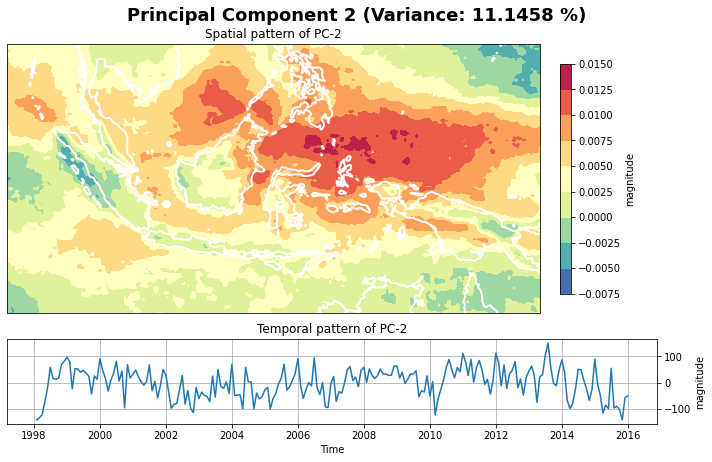

tempo_patt.shape:  (216,) 



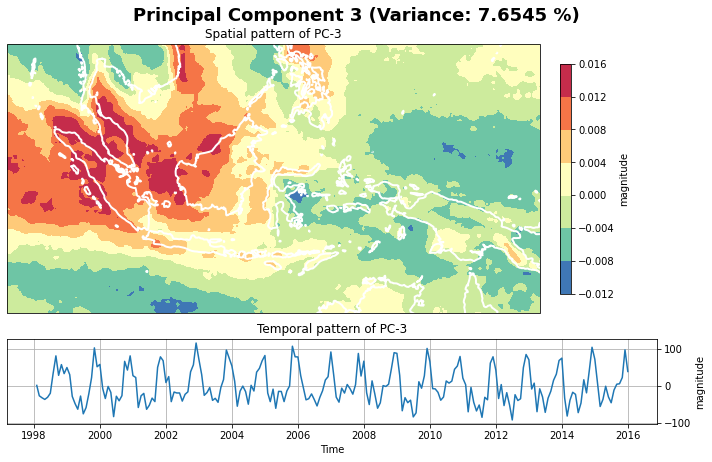

tempo_patt.shape:  (216,) 



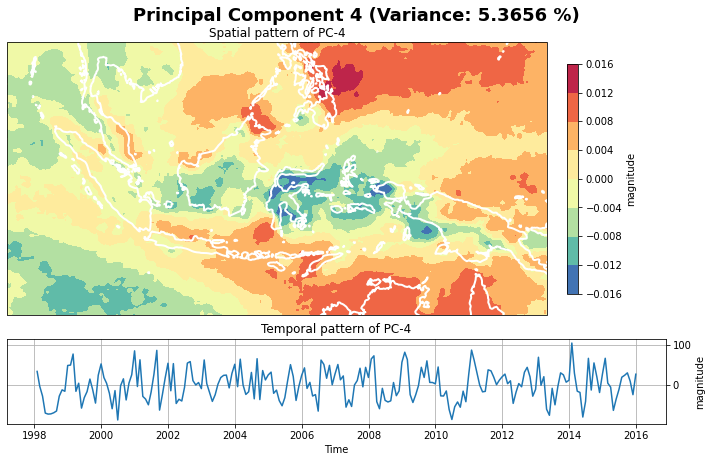

tempo_patt.shape:  (216,) 



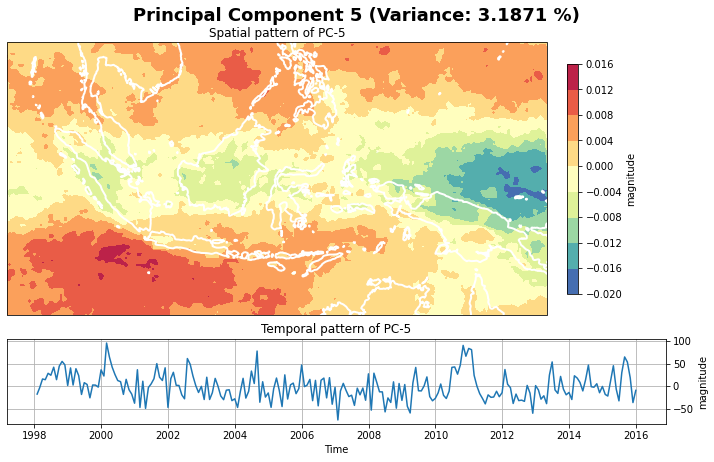

In [ ]:
print("Chosen Principal Components: ", chosen_PC, "\n")

for i_PC in chosen_PC:
  ##### Spatial pattern (component, EOF) #####
  spatial_patt = spatial_EOF.sel(princomp=i_PC).values
  lat = spatial_EOF.lat.values
  lon = spatial_EOF.lon.values  

  ##### Temporal pattern (score, projected data) #####
  tempo_patt = score[i_PC-1, :]
  times = data.time.values
  print("tempo_patt.shape: ", tempo_patt.shape, '\n')

  ##### Plot #####
  fig = plt.figure(figsize=(10,6.5))

  # Spatial
  ax0 = plt.subplot2grid((4,1), (0,0), rowspan=3, projection=ccrs.Mercator())
  ax0.set_title("Spatial pattern of PC-%d" %(i_PC))
  PC_map = ax0.contourf(lon, lat, spatial_patt, zorder=1, cmap='Spectral_r', 
                        transform=ccrs.PlateCarree())
  plt.colorbar(PC_map, shrink=0.8, pad=0.03).set_label("magnitude")
  ax0.coastlines(lw=2, color='white', zorder=2)

  ## Temporal
  ax1 = plt.subplot2grid((4,1), (3,0), rowspan=1)
  ax1.set_title("Temporal pattern of PC-%d" %(i_PC))
  ax1.plot(times, tempo_patt)
  ax1.grid(which='both')
  ax1.set_ylabel('magnitude'); ax1.set_xlabel('Time')
  ax1.yaxis.set_label_position('right')
  ax1.yaxis.tick_right()

  plt.tight_layout(h_pad=1.7)
  plt.suptitle("Principal Component %d (Variance: %.4f %%)" %(i_PC, percent_var[i_PC-1]), weight='bold', size=18)
  plt.subplots_adjust(top=0.92)
  plt.show()

## A.5. FFT pada mode temporal


Chosen Principal Components:  [1 2 3 4 5] 

PC- 1 [ 0 ]  tempo_patt.shape:  (216,) 



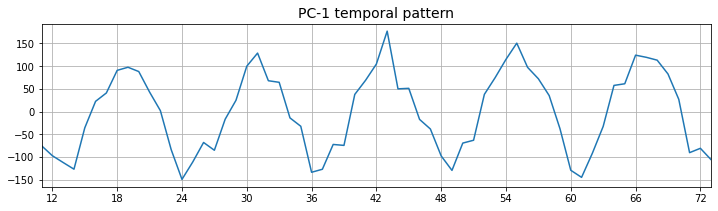

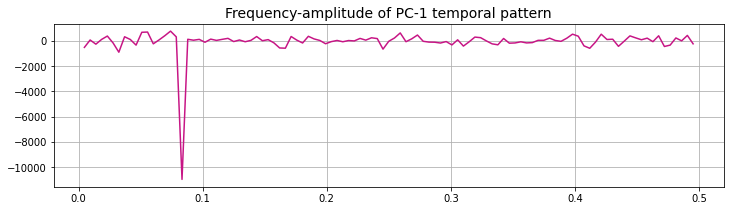

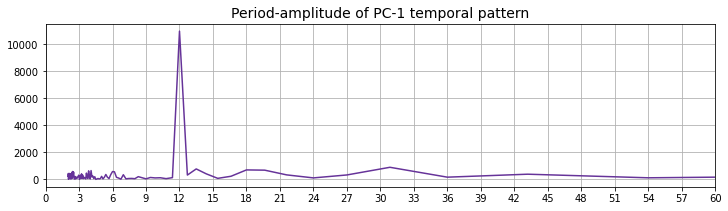

PC- 2 [ 1 ]  tempo_patt.shape:  (216,) 



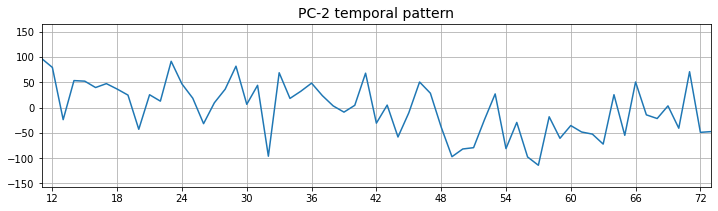

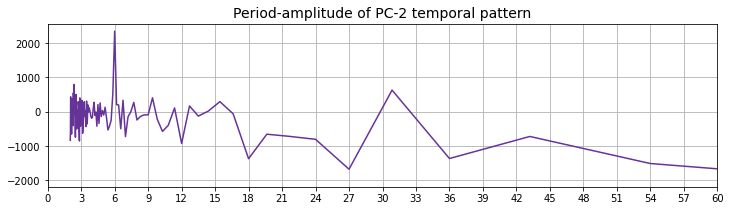

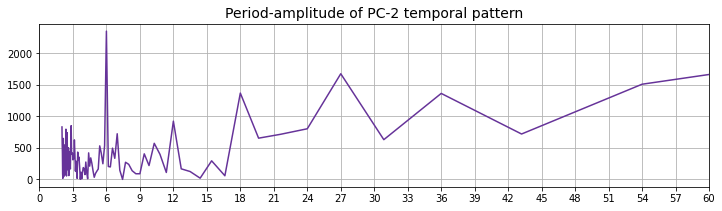

PC- 3 [ 2 ]  tempo_patt.shape:  (216,) 



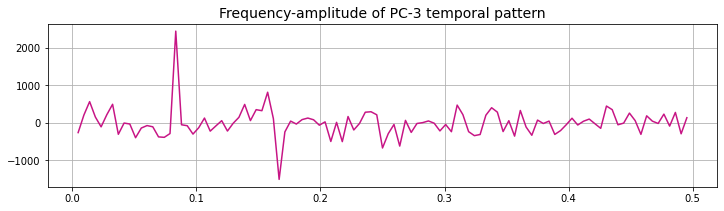

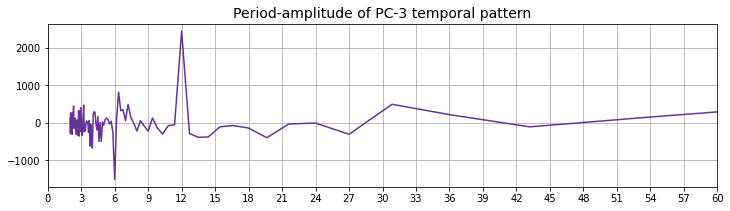

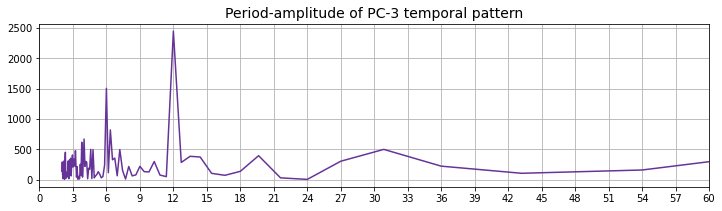

PC- 4 [ 3 ]  tempo_patt.shape:  (216,) 



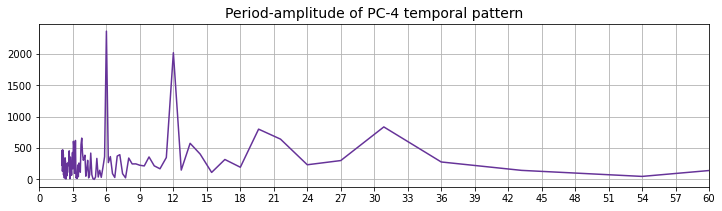

PC- 5 [ 4 ]  tempo_patt.shape:  (216,) 



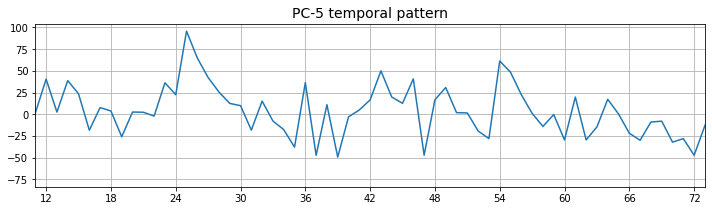

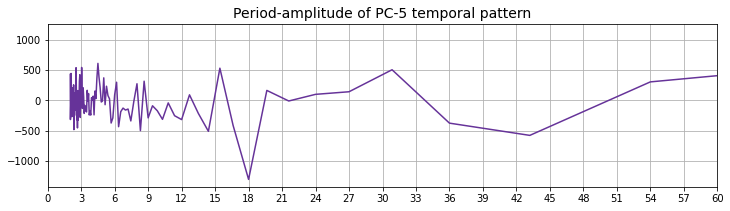

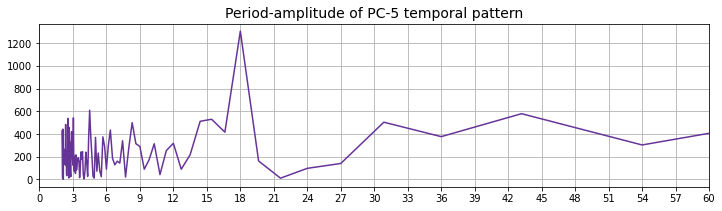

In [ ]:
print("Chosen Principal Components: ", chosen_PC, "\n")

for i_PC in chosen_PC:
  # Temporal pattern (score, projected data)
  tempo_patt = score[i_PC-1, :]
  times = data.time.values
  print("PC-", i_PC,"[", i_PC-1, "]  tempo_patt.shape: ", tempo_patt.shape, '\n')

  # Cek
  plt.figure(figsize=(12,3))
  plt.plot(tempo_patt)
  plt.title("PC-%d temporal pattern" %(i_PC), size=14)
  plt.xticks(np.arange(0, 120, 6))
  plt.xlim([11,73])
  plt.grid(); plt.show()

  # FFT of temporal pattern
  signal_fft = np.fft.fft(tempo_patt).real
  signal_frq = np.fft.fftfreq(len(times)).real # Unit = 1/1 bulan
    # Take positive frequencies only
  signal_fft = signal_fft[np.where(signal_frq >0)]
  signal_frq = signal_frq[np.where(signal_frq >0)]

  # Plot of fft frequencies
  plt.figure(figsize=(12,3))
  plt.title("Frequency-amplitude of PC-%d temporal pattern" %(i_PC), size=14)
  plt.plot(signal_frq, signal_fft, color='mediumvioletred')
  #plt.ylim([-5000, 5000])
  plt.grid(); plt.show()

  # Plot of fft periods
  plt.figure(figsize=(12,3))
  plt.title("Period-amplitude of PC-%d temporal pattern" %(i_PC), size=14)
  plt.plot(1/signal_frq, signal_fft, color='rebeccapurple')
  plt.xticks(np.arange(0, 120, 3))
  plt.xlim([0, 60])
  #plt.ylim([-5000, 5000])
  plt.grid(); plt.show()

  # Plot of fft periods (absolute)
  plt.figure(figsize=(12,3))
  plt.title("Period-amplitude of PC-%d temporal pattern" %(i_PC), size=14)
  plt.plot(1/signal_frq, abs(signal_fft), color='rebeccapurple')
  plt.xticks(np.arange(0, 120, 3))
  plt.xlim([0, 60])
  #plt.ylim([-5000, 5000])
  plt.grid(); plt.show()

------
# B. Nomor 2 : **Clustering**
1. [x] Rekonstruksi ulang curah hujan bulanan dari pola spasial (fungsi basis) dan pola temporal (fungsi ekspansi) komponen utama dari no. A.4.)
2. [x] Hitung rata-rata klimatologisnya.
3. [ ] Terapkan **_hierarchical clustering_**.
4. [ ] Gambarkan dendrogram dan tentukan jumlah clusternya yang relevan serta alasannya.
5. [ ] Gambarkan _assingment cluster_ masing-masing titik secara spasial.
6. [ ] Apakah hasil clustering tersebut menunjukkan pengelompokkan yang berarti? <u> Dukung analisa</u> dengan menggambarkan sampel curah hujan klimatologis masing-masign cluster.


## B.1. Rekonstruksi Data
`component` --> cols of eigenvector | `variance` --> eigenvalue \
Dimensions:  ('time', 'lat', 'lon') (216, 122, 242)

## B.2. Rata-rata musiman
Rata-rata per bulan sepanjang tahunnya

Chosen Principal Components:  [1 2 3 4 5] 

chosen projected data:  (5, 216) 

chosen reconstructed data:  (29524, 216) 

chosen reconstructed data reshaped:  (216, 122, 242) 



<xarray.DataArray 'principal' (time: 216, lat: 122, lon: 242)>
array([[[ 0.22151035,  0.27782777,  0.39091694, ...,  0.5463605 ,
          0.50688603,  0.56245469],
        [ 0.26625846,  0.31360207,  0.34466294, ...,  0.58833288,
          0.58707582,  0.57713455],
        [ 0.28618841,  0.31976159,  0.33159954, ...,  0.59173376,
          0.58611281,  0.58354591],
        ...,
        [-1.43206388, -1.42276374, -1.34841403, ..., -0.05667116,
         -0.0411089 ,  0.01789466],
        [-1.40158376, -1.34448728, -1.3602659 , ...,  0.04769593,
          0.05507638,  0.03343799],
        [-1.36346295, -1.33730209, -1.32470245, ...,  0.02082442,
          0.00685261, -0.00176404]],

       [[ 0.43368599,  0.52470106,  0.67595248, ...,  0.61951557,
          0.5813979 ,  0.62624651],
        [ 0.47370867,  0.54470716,  0.59104263, ...,  0.67429954,
          0.6733233 ,  0.66693867],
        [ 0.53593974,  0.58906255,  0.61834447, ...,  0.67760428,
          0.65884867,  0.66318165],
        ...,
        [-1.24158279, -1.19922911, -1.13708439, ..., -0.45408402,
         -0.43066924, -0.35734027],
        [-1.2374362 , -1.15490702, -1.15140595, ..., -0.36927721,
         -0.35196307, -0.34783442],
        [-1.2107722 , -1.16890024, -1.14872833, ..., -0.401117  ,
         -0.39404205, -0.38264077]],

       [[ 0.61699802,  0.73144181,  0.89528059, ...,  0.68333518,
          0.64858494,  0.69022712],
        [ 0.64436466,  0.73689027,  0.78544652, ...,  0.74539511,
          0.7462331 ,  0.74922038],
        [ 0.73046503,  0.80276918,  0.8314718 , ...,  0.74887023,
          0.72560526,  0.7414051 ],
        ...,
        [-1.14814248, -1.09786206, -1.04015314, ..., -0.71165171,
         -0.67964608, -0.61580889],
        [-1.16075972, -1.08000242, -1.05781535, ..., -0.63807937,
         -0.61748317, -0.61374417],
        [-1.13857921, -1.10151402, -1.07075199, ..., -0.68021667,
         -0.66677584, -0.6427894 ]],

       ...,

       [[ 0.09805222,  0.1851699 ,  0.21648497, ..., -0.49777696,
         -0.5380624 , -0.46742176],
        [ 0.05676248,  0.16901193,  0.19815873, ..., -0.53528098,
         -0.5426725 , -0.53822879],
        [-0.00233982,  0.15475187,  0.17913898, ..., -0.55265736,
         -0.54907663, -0.54572587],
        ...,
        [-0.12648841, -0.18471639, -0.09452749, ...,  1.10535993,
          1.13160716,  1.10061509],
        [-0.06044558, -0.12095028, -0.09260511, ...,  1.20161588,
          1.18856776,  1.11927857],
        [-0.02703193, -0.03603038,  0.00998357, ...,  1.09466729,
          1.06153827,  1.09267849]],

       [[-0.05102736, -0.07876859, -0.11807733, ..., -0.61544612,
         -0.65205092, -0.62163804],
        [-0.10037647, -0.13389413, -0.1087551 , ..., -0.67842075,
         -0.7188241 , -0.68065647],
        [-0.19371733, -0.17434967, -0.15894847, ..., -0.66665219,
         -0.66918305, -0.63486049],
        ...,
        [-0.5333692 , -0.59366683, -0.59287028, ...,  0.15124218,
          0.13157753,  0.17250048],
        [-0.52299992, -0.5802158 , -0.54426243, ...,  0.23960722,
          0.20222651,  0.20643941],
        [-0.47724765, -0.49940856, -0.51778411, ...,  0.21822479,
          0.19418087,  0.27884572]],

       [[ 0.1335076 ,  0.13069202,  0.15918951, ...,  0.46632482,
          0.45140371,  0.48073336],
        [ 0.1551663 ,  0.14989787,  0.14650849, ...,  0.49329349,
          0.49208167,  0.50102407],
        [ 0.15620991,  0.13569998,  0.11080194, ...,  0.50359524,
          0.50947519,  0.52220854],
        ...,
        [-1.13941467, -1.15683794, -1.12526709, ..., -0.26755909,
         -0.26428248, -0.24603054],
        [-1.13038096, -1.11989444, -1.12968843, ..., -0.20628829,
         -0.21091154, -0.24134187],
        [-1.09976168, -1.11405691, -1.11517607, ..., -0.20365953,
         -0.2254147 , -0.23658631]]])
Coordinates:
  * time     (time) datetime64[ns] 1998-01-31 1998-02-28 ... 2015-12-31
  * lon      (lon) float64 89.88 90.12 90.38 90.62 ... 149.4 149.6 149.9 150.

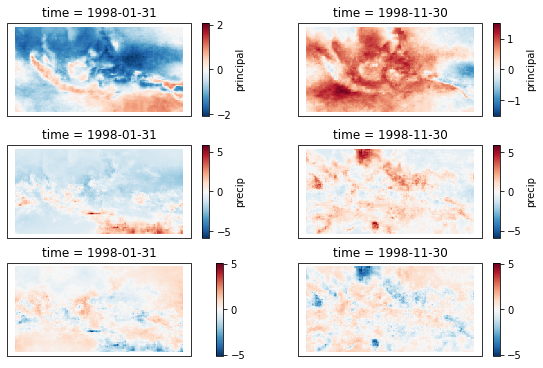

In [ ]:
# Choose PC
print("Chosen Principal Components: ", chosen_PC, "\n")
i_PC = chosen_PC-1

#chosen_component = component[:,:]
chosen_component = component[:,i_PC]

# Deriving new dataset (projected data)
chosen_scores = chosen_component.T @ pca_data
print("chosen projected data: ", chosen_scores.shape, '\n')

# Getting old data back
chosen_pca_data = (chosen_component.T.T @ chosen_scores) + row_means
print("chosen reconstructed data: ", chosen_pca_data.shape, '\n')

# Reshape
chosen_pca_data = np.reshape(chosen_pca_data.T, (n_time, n_lat, n_lon))
print("chosen reconstructed data reshaped: ", chosen_pca_data.shape, "\n")

# Ubah ke xarray
principal_data = xr.DataArray(chosen_pca_data, name='principal', 
                              coords=data.coords, dims=data.dims,
                              attrs={"description":"Data reconstructed from PCA components"})


# Cek
fig, ax = plt.subplots(3,2, figsize=(8,5), constrained_layout=True,
                       subplot_kw={'projection': ccrs.Mercator()})
# Row 1 : principal
principal_data.isel(time=0).plot(ax=ax[0,0], transform=ccrs.PlateCarree())
principal_data.isel(time=10).plot(ax=ax[0,1], transform=ccrs.PlateCarree())
# Row 2 : original data
data.isel(time=0).plot(ax=ax[1,0], transform=ccrs.PlateCarree())
data.isel(time=10).plot(ax=ax[1,1], transform=ccrs.PlateCarree())
# Row 3 : difference
(principal_data-data).isel(time=0).plot(ax=ax[2,0], transform=ccrs.PlateCarree())
(principal_data-data).isel(time=10).plot(ax=ax[2,1], transform=ccrs.PlateCarree())

for i in range(2):
  for j in range(2):
    ax[i,j].set_xlabel(""); ax[i,j].set_ylabel("")

principal_data

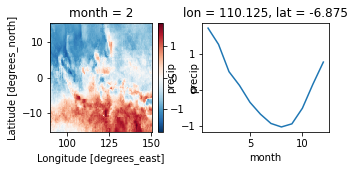

<xarray.DataArray 'precip' (month: 12, lat: 122, lon: 242)>
array([[[-2.15352058e-01, -2.32705961e-01, -2.48702346e-01, ...,
          8.01155951e-01,  7.78959202e-01,  8.44303075e-01],
        [-1.59543794e-01, -1.67688565e-01, -1.83355508e-01, ...,
          8.18585278e-01,  9.18957510e-01,  9.51391099e-01],
        [-2.24883605e-01, -2.13923981e-01, -2.42274634e-01, ...,
          8.39747177e-01,  9.17605215e-01,  9.55477856e-01],
        ...,
        [-9.31349733e-01, -9.20534761e-01, -8.97863455e-01, ...,
         -5.85132594e-01, -5.83450558e-01, -5.65695933e-01],
        [-9.32761724e-01, -8.79267874e-01, -9.00581112e-01, ...,
         -5.83966398e-01, -5.63064447e-01, -5.83779620e-01],
        [-9.21876982e-01, -9.08078930e-01, -9.08908375e-01, ...,
         -5.33229001e-01, -5.32603470e-01, -6.44481341e-01]],

       [[ 2.09975426e-01,  8.29145913e-02,  1.89792406e-01, ...,
          8.68560829e-01,  8.58300259e-01,  8.53006496e-01],
        [ 2.15462109e-01,  1.86261193e-01,  1.22667527e-01, ...,
          9.98137642e-01,  9.56534828e-01,  9.12297585e-01],
        [ 3.43683029e-01,  2.07323381e-01,  1.58479760e-01, ...,
          9.24793192e-01,  9.03572425e-01,  8.68725177e-01],
        ...,
        [-1.00586885e+00, -1.00104588e+00, -9.76614767e-01, ...,
         -7.53269590e-01, -7.20375788e-01, -7.04503110e-01],
        [-9.97634940e-01, -9.55762054e-01, -9.75732478e-01, ...,
         -7.28561488e-01, -7.29164473e-01, -7.22182386e-01],
        [-9.96765621e-01, -9.91580115e-01, -9.96151617e-01, ...,
         -7.32777078e-01, -7.45512912e-01, -7.41100297e-01]],

       [[ 8.42798840e-01,  9.64539202e-01,  9.57933571e-01, ...,
          1.03762256e+00,  1.08582786e+00,  1.04679489e+00],
        [ 9.29452132e-01,  9.78182367e-01,  9.35041859e-01, ...,
          1.10099579e+00,  1.03781883e+00,  1.01196364e+00],
        [ 1.05848819e+00,  1.02183543e+00,  1.04361335e+00, ...,
          1.04765895e+00,  9.40398038e-01,  8.93363890e-01],
        ...,
        [-8.84437413e-01, -8.74088301e-01, -8.51766327e-01, ...,
         -6.71973355e-01, -6.51990676e-01, -6.03093298e-01],
        [-8.93841266e-01, -8.38937489e-01, -8.42296945e-01, ...,
         -6.97627927e-01, -6.77680756e-01, -6.33711820e-01],
        [-9.16102329e-01, -8.98494328e-01, -8.79764988e-01, ...,
         -6.98377671e-01, -6.76042894e-01, -6.72462353e-01]],

       ...,

       [[-1.67432247e-01, -1.88114101e-01, -2.35043198e-01, ...,
         -3.74635521e-01, -3.68483520e-01, -4.10114127e-01],
        [-2.10879393e-01, -2.26683947e-01, -2.31841764e-01, ...,
         -4.58364085e-01, -4.59229220e-01, -4.66476999e-01],
        [-2.07638727e-01, -2.24134864e-01, -2.58484769e-01, ...,
         -4.73237999e-01, -4.75351460e-01, -4.85512030e-01],
        ...,
        [ 4.11251837e-02, -3.11769719e-02, -2.70385801e-02, ...,
          8.77777463e-01,  8.40236446e-01,  7.28755514e-01],
        [ 4.47082164e-02, -1.14088188e-02, -2.52269237e-02, ...,
          1.02536584e+00,  9.22016396e-01,  8.33469275e-01],
        [ 3.12865662e-02,  8.24116874e-04, -2.84211823e-02, ...,
          9.43409573e-01,  9.00324222e-01,  1.00052321e+00]],

       [[ 2.84964800e-01,  2.00380903e-01,  7.42260076e-03, ...,
         -2.43946966e-01, -2.33741898e-01, -1.90081749e-01],
        [ 2.42684164e-01,  2.03268248e-01,  7.22575739e-02, ...,
         -2.27789930e-01, -2.59688421e-01, -2.57497504e-01],
        [ 3.34221724e-02,  7.84231847e-02,  1.22870788e-02, ...,
         -1.95350084e-01, -2.16093580e-01, -2.04256524e-01],
        ...,
        [-2.17325559e-01, -2.38251122e-01, -2.22018747e-01, ...,
         -1.46017532e-01, -1.43026770e-01, -1.17141241e-01],
        [-2.72605852e-01, -2.42970653e-01, -2.19811177e-01, ...,
         -1.49379873e-01, -9.68094951e-02, -1.36797598e-01],
        [-2.04720867e-01, -1.87701277e-01, -1.87970611e-01, ...,
         -1.71125463e-01, -1.83316934e-01, -1.35285635e-01]],

       [[-2.02287086e-01, -2.22361356e-01, -1.82191008e-01, ...,
       

In [ ]:
pcpl_clima_mean = principal_data.groupby('time.month').mean(dim='time')
clima_mean = data.groupby('time.month').mean(dim='time')

# Cek
fig, ax = plt.subplots(1,2, figsize=(5,2))
clima_mean.isel(month=1).plot(ax=ax[0])
clima_mean.sel(lat=-7, lon=110, method='nearest').plot(ax=ax[1])
plt.show()

pcpl_clima_fg = pcpl_clima_mean.plot(col='month', col_wrap=3, figsize=(15,9),
                                     subplot_kws={'projection':ccrs.Mercator()},
                                     transform=ccrs.PlateCarree(),
                                     cbar_kwargs={"shrink":.9, 'aspect':40, 'pad':0.02}, 
                                     cmap='BrBG',
                                     )
pcpl_clima_fg.map(lambda: plt.gca().coastlines())
plt.show()

clima_fg = clima_mean.plot(col='month', col_wrap=3, figsize=(15,9),
                           subplot_kws={'projection':ccrs.Mercator()},
                           transform=ccrs.PlateCarree(),
                           cbar_kwargs={"shrink":.9, 'aspect':40, 'pad':0.02}, 
#                           cmap='BrBG',
                           )
clima_fg.map(lambda: plt.gca().coastlines())
plt.show()


clima_mean

## B.3. Hierarchical Clustering
Cluster lokasi-lokasi berdasarkan nilai korelasi (vektor eigen, komponen, EOF) PC-PCnya.

`n_lat*n_lon` lokasi/grid/stasiun dikelompokkan berdasarkan nilai PC `[pc1, pc2, pc3, ...]`nya.

stasiun v.s. PC --> `[stasiun, (PC1-...)]` --> `[29524,5]`

`scipy.cluster.hierarchy.linkage()` crash

[Clustering data set with multiple dimensions](https://datascience.stackexchange.com/questions/67507/clustering-data-set-with-multiple-dimensions)

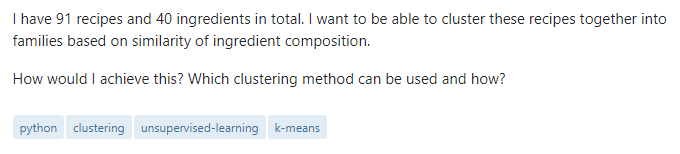

image.png

In [ ]:
# Choose PC
print("Chosen Principal Components: ", chosen_PC, "\n")

### Ambil nilai komponen PC
# princomp, n_lat, n_lon
#n_princomp = len(spatial_EOF.princomp)
n_princomp = len(chosen_PC)
print(spatial_EOF.dims,":", spatial_EOF.sel(princomp=chosen_PC).shape,"\n")

### Ubah bentuk menjadi [lokasi, PC]
points_PC = np.reshape(spatial_EOF.sel(princomp=chosen_PC).values, (n_princomp, n_lat*n_lon)).T
print("points_PCs.shape: ", points_PC.shape, "\n")

# n_cluster=40 biar gak banyak hitung; gak mau analisis lebih dari 40 cluster
agg_link = skcst.AgglomerativeClustering(affinity='euclidean',
                                         n_clusters=4, 
                                         linkage='ward', compute_distances=True)
agg_link.fit(points_PC)
print(agg_link, '\n')

print("distances.shape :", agg_link.distances_.shape,"\n",
      "labels :", agg_link.labels_.shape, agg_link.labels_,)
agg_labels = agg_link.labels_
print(agg_labels)

Chosen Principal Components:  [1 2 3 4 5] 

('princomp', 'lat', 'lon') : (5, 122, 242) 

points_PCs.shape:  (29524, 5) 

AgglomerativeClustering(compute_distances=True, n_clusters=4) 

distances.shape : (29523,) 
 labels : (29524,) [0 0 0 ... 3 3 3]
[0 0 0 ... 3 3 3]


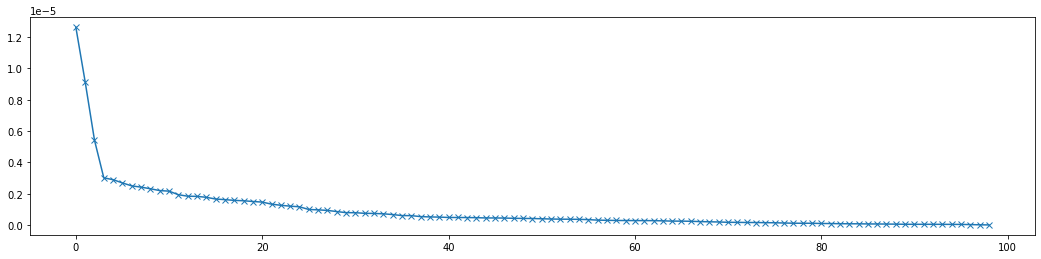

In [ ]:
plt.figure(figsize=(18,4))
plt.plot(agg_link.distances_[:100]); plt.show()
plt.figure(figsize=(18,4))
plt.plot(np.sort(np.diff(agg_link.distances_[:100]))[::-1], '-x'); plt.show()

## B.4. Dendogram

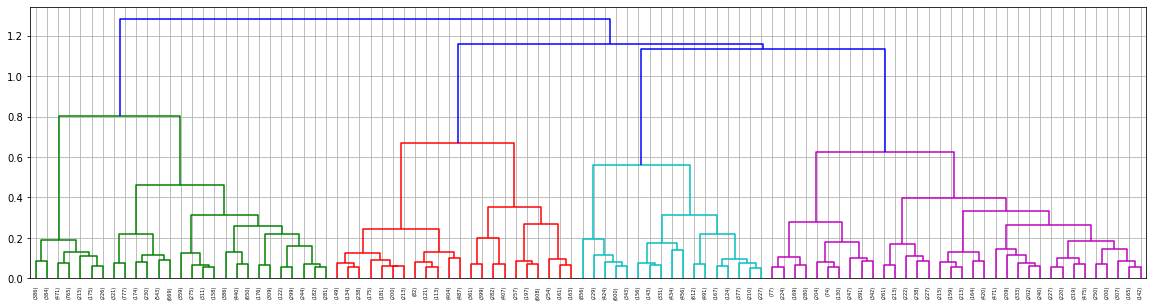

In [ ]:
## Dari tutorial di scikit-learn
def plot_dendrogram(model, **kwargs):
  '''
  Create linkage matrix and then plot the dendrogram
  create the counts of samples under each node
  '''
  from scipy.cluster.hierarchy import dendrogram
  counts = np.zeros(model.children_.shape[0])
  n_samples = len(model.labels_)
  for i, merge in enumerate(model.children_):
      current_count = 0
      for child_idx in merge:
          if child_idx < n_samples:
              current_count += 1  # leaf node
          else:
              current_count += counts[child_idx - n_samples]
      counts[i] = current_count

  linkage_matrix = np.column_stack([model.children_, model.distances_,
                                    counts]).astype(float)

  # Plot the corresponding dendrogram
  dendrogram(linkage_matrix, **kwargs)

plt.figure(figsize=(20,5))
plot_dendrogram(agg_link, labels=agg_link.labels_, truncate_mode='lastp', p=100)
plt.grid(True); plt.show()

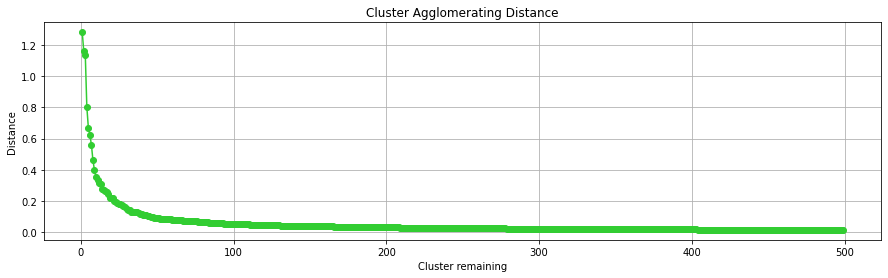

(None, None)

In [ ]:
# Fungsi dendogram
def fancy_dendrogram(model, *args, **kwargs):
    '''
    Draw dendrogram of a matrix, then plot.
    Use args & kwargs from scipy.cluster.hierarchy.dendrogram().
    Pass kwargs 'no_plot' to not plot.
    Additional kwargs:
        max_d : Draw vertical line indicating max_d (a distance) value.
        color_threshold : 
    '''
    import matplotlib.pyplot as plt
    from scipy.cluster.hierarchy import dendrogram

    distances = []
    
    # Add new kwargs: max_d & color_treshold
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    ddata = dendrogram(linkage_matrix, **kwargs)
    
    # Choose whether to plot or not (kwargs: 'no_plot')
    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            # Dapatkan jarak penggabungan cluster
            distances.append(y)

            if y > annotate_above:
                # Annotate points with dots
                plt.plot(x, y, 'o', c=c)
                # Annotate points with its values
                #plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                #             textcoords='offset points',
                #             va='top', ha='center')
                
        # Draw vertical line indicating max_d
        if max_d:
            plt.axhline(y=max_d, c='grey', ls='--')
            
    return ddata, distances


# Gambarkan dendrogram & dapatkan jarak antar penggabungan cluster
plt.figure(figsize=(15,7))
dendrogram, agg_getdist = fancy_dendrogram(agg_link, labels=agg_link.labels_,
                                           truncate_mode='lastp', p=500,
#                                           max_d=0.75
                                           )
plt.grid(axis='y'); plt.show()

# Gambarkan jarak antar penggabungan cluster
  # Urutkan dari paling jauh ke dekat (sumbu y paling atas ke bawah) (descending)
agg_getdist = np.sort(np.array(agg_getdist))[::-1]

  # Plot
plt.figure(figsize=(15,4))
plt.plot(np.arange(1,len(agg_getdist)+1), agg_getdist, "-o", color='limegreen')
plt.title("Cluster Agglomerating Distance")
plt.xlabel("Cluster remaining")
plt.ylabel("Distance")
plt.grid(), plt.show()

In [ ]:
  # Plot
plt.figure(figsize=(15,4))
plt.plot(np.arange(1,len(agg_getdist)+1), agg_getdist, "-o", color='limegreen')
plt.title("Cluster Agglomerating Distance")
plt.xlabel("Cluster remaining"); plt.ylabel("Distance between agglomerated cluster")
plt.xlim([0, 50])
#plt.axhline(0.75, ls='--', color='grey')
plt.axvline(4, ls='--', color='grey')
plt.xticks(np.arange(0,51,2))
plt.grid(), plt.show()

(None, None)

### Silhouette Score
dari tutorial [Selecting the number of clusters with silhouette analysis on KMeans clustering](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py)

Panjang nyampur sama `matplotlib`nya

For n_clusters = 3 The average silhouette_score is : 0.2603914248374365
n_clusters, silhouette_avg 3 0.2603914248374365 

For n_clusters = 4 The average silhouette_score is : 0.30586152723024557
n_clusters, silhouette_avg 4 0.30586152723024557 

For n_clusters = 5 The average silhouette_score is : 0.31102547752659354
n_clusters, silhouette_avg 5 0.31102547752659354 

For n_clusters = 6 The average silhouette_score is : 0.3173510676810234
n_clusters, silhouette_avg 6 0.3173510676810234 

For n_clusters = 7 The average silhouette_score is : 0.3108406890969322
n_clusters, silhouette_avg 7 0.3108406890969322 

For n_clusters = 8 The average silhouette_score is : 0.3250731991388596
n_clusters, silhouette_avg 8 0.3250731991388596 



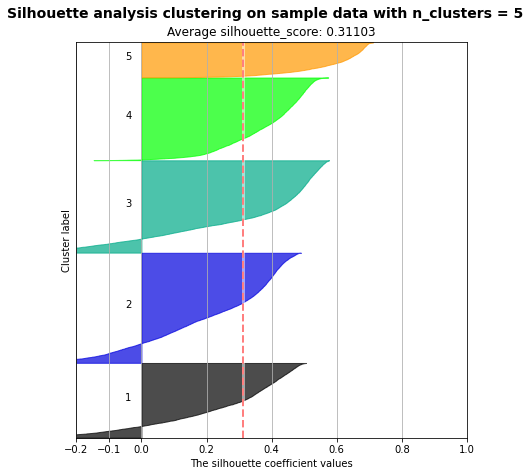

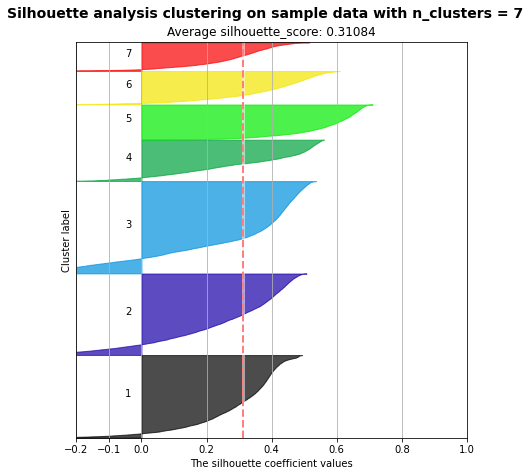

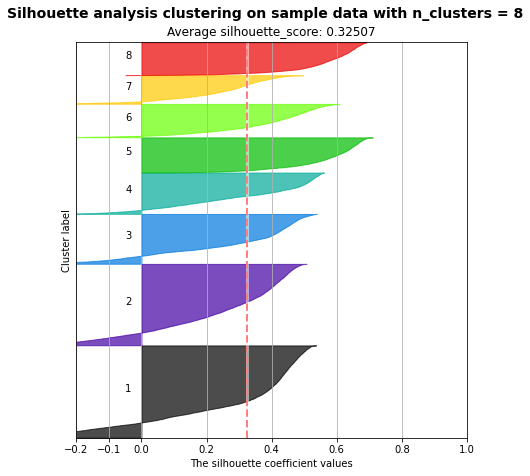

agg_silh:  [[3, 4, 5, 6, 7, 8], [0.2603914248374365, 0.30586152723024557, 0.31102547752659354, 0.3173510676810234, 0.3108406890969322, 0.3250731991388596]]


In [ ]:
points_PC

def silhouette_express(points, range_n_clusters=[4], x_label='', y_label=''):
  '''
  points: array, data yang mau dicluster
  range_n_clusters: banyak cluster yang mau dicoba (looping). Default=4

  return:
    silh_score[[n cluster], [mean silhouette score]]
  '''
  import sklearn.cluster as skcst
  import sklearn.metrics as skm
  import matplotlib.cm as cm
  import matplotlib.pyplot as plt
  import numpy as np

  silh_scores = [[],[]]
  X = points

  for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1,1)
    fig.set_size_inches(7, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([-1, len(X) + (n_clusters + 1) * 10])

       # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    #clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    #cluster_labels = clusterer.fit_predict(X)
    clusterer = skcst.AgglomerativeClustering(n_clusters=n_clusters,
                                              affinity='euclidean', 
                                              linkage='ward',
                                              )
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = skm.silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = skm.silhouette_samples(X, cluster_labels)

    silh_scores[0].append(n_clusters)
    silh_scores[1].append(silhouette_avg)
    print("n_clusters, silhouette_avg", n_clusters, silhouette_avg,"\n")

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_title("Average silhouette_score: %.5f" %(silhouette_avg))
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--", lw=2)
    ax1.axvline(x=silhouette_avg, color="white", alpha=0.5, lw=3)

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.2, -0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    ax1.grid(True)

    plt.suptitle(("Silhouette analysis clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.subplots_adjust(top = 0.91)

  plt.show()
  return silh_scores

range_clusters =[3, 4, 5, 6, 7, 8]
#range_clusters =[2]

agg_silh = silhouette_express(points_PC, range_n_clusters=range_clusters)
print("agg_silh: ", agg_silh)

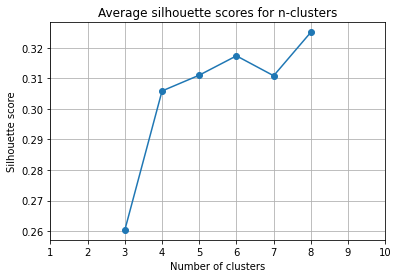

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(agg_silh[0], agg_silh[1], '-o')
plt.xticks(range(1, 11))
plt.title("Average silhouette scores for n-clusters")
plt.xlabel("Number of clusters"); plt.ylabel("Silhouette score")
plt.grid(True); plt.show()

## B.5. Visualisasi Cluster Assignment

agg_labels.shape:  (29524,)


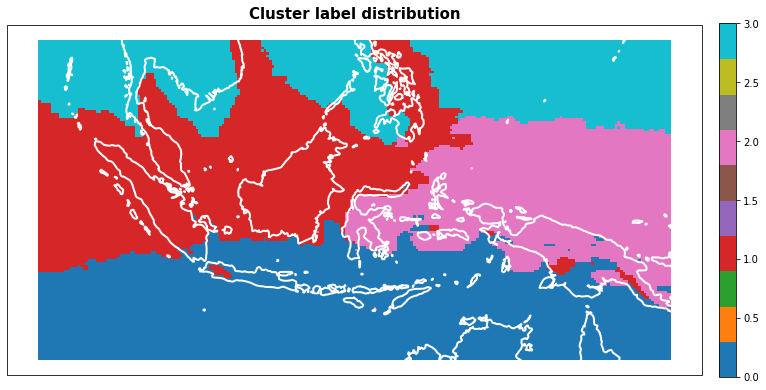

In [ ]:
# Labels: AgglomerativeClustering().labels_
agg_labels
print("agg_labels.shape: ", agg_labels.shape)

# Reshape menjadi lat-lon
agg_spatial = np.reshape(agg_labels, (n_lat, n_lon))
lat = spatial_EOF.lat
lon = spatial_EOF.lon

# Plot
import matplotlib.colors as mc
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection=ccrs.Mercator())

label_map = ax.pcolormesh(lon, lat, agg_spatial, 
                          transform=ccrs.PlateCarree(), cmap='tab10')
#label_map = ax.contourf(spatial_EOF.lon, spatial_EOF.lat, agg_spatial, 
#                        transform=ccrs.PlateCarree(), cmap='tab10')

plt.title("Cluster label distribution", size=15, weight='bold')
plt.colorbar(label_map, shrink=0.65, extend='neither', pad=.02)
ax.coastlines(color='white', lw=2)

plt.show()

## B.6. Plot klimatologis uji clustering

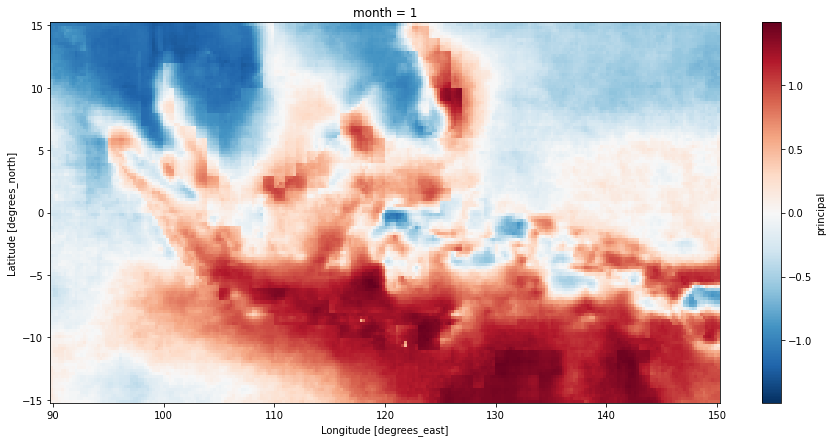

In [ ]:
pcpl_clima_mean.sel(month=1).plot(figsize=(15,7))

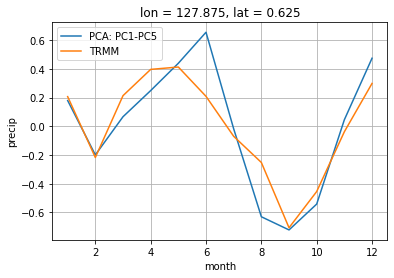

In [ ]:
d_lat= 0.5
d_lon= 127.8

pcpl_clima_mean.sel(lat=d_lat, lon=d_lon, method='nearest').plot(label="PCA: PC1-PC5")
clima_mean.sel(lat=d_lat, lon=d_lon, method='nearest').plot(label="TRMM")
plt.legend(loc=2)
plt.grid(True); plt.show()